# Imports

In [1]:
import os
import matplotlib.pyplot as plt

In [2]:
import hashlib

In [3]:
import cv2

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
import numpy as np

# Data Loading

In [7]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Functions

In [8]:
def get_file_hash(file_path):
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
    return file_hash

In [9]:
def find_and_remove_duplicates(directory):
    image_hashes = {}
    duplicates = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for image in os.listdir(category_path):
                image_path = os.path.join(category_path, image)
                img_hash = get_file_hash(image_path)
                
                if img_hash in image_hashes:
                    duplicates.append((image_path, image_hashes[img_hash]))
                    print(f"Removing duplicate: {image_path}")
                    os.remove(image_path)  # Remove the duplicate file
                else:
                    image_hashes[img_hash] = image_path
    return duplicates

In [10]:
def plot_sample_images(directory, categories, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)[:num_samples]  # Select a few images
        
        for j, image_file in enumerate(images):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB for display
            
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(image)
            plt.title(category)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
        "train_f1": [],
        "val_f1": []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect labels for metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calculate training metrics
        train_accuracy = 100 * correct / total
        train_precision = precision_score(y_true, y_pred, average='macro')
        train_recall = recall_score(y_true, y_pred, average='macro')
        train_f1 = f1_score(y_true, y_pred, average='macro')

        # Validation
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(model, val_loader, criterion)

        # Save metrics
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["train_precision"].append(train_precision)
        history["val_precision"].append(val_precision)
        history["train_recall"].append(train_recall)
        history["val_recall"].append(val_recall)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return history

In [12]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect labels for metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = 100 * correct / total
    val_precision = precision_score(y_true, y_pred, average='macro')
    val_recall = recall_score(y_true, y_pred, average='macro')
    val_f1 = f1_score(y_true, y_pred, average='macro')

    val_loss /= len(val_loader)
    return val_loss, val_accuracy, val_precision, val_recall, val_f1


In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect labels for metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * correct / total
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy on test set: {accuracy:.2f}%')
    print(f'Precision on test set: {precision:.2f}')
    print(f'Recall on test set: {recall:.2f}')
    print(f'F1-score on test set: {f1:.2f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_loader.dataset.classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)  # Adjusted to dynamic length based on training

    plt.figure(figsize=(18, 12))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(3, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot precision
    plt.subplot(3, 2, 3)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot recall
    plt.subplot(3, 2, 4)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    
    # Plot F1-score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, history['train_f1'], label='Train F1-score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-score')
    plt.title('F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    
    # Adjust layout and display all plots
    plt.tight_layout()
    plt.show()


# EDA/Data Visualization

In [15]:
train_counts = {}
test_counts = {}

In [16]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [17]:
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    train_counts[category] = len(os.listdir(train_category_dir))

In [18]:
for category in categories:
    test_category_dir = os.path.join(test_dir, category)
    test_counts[category] = len(os.listdir(test_category_dir))

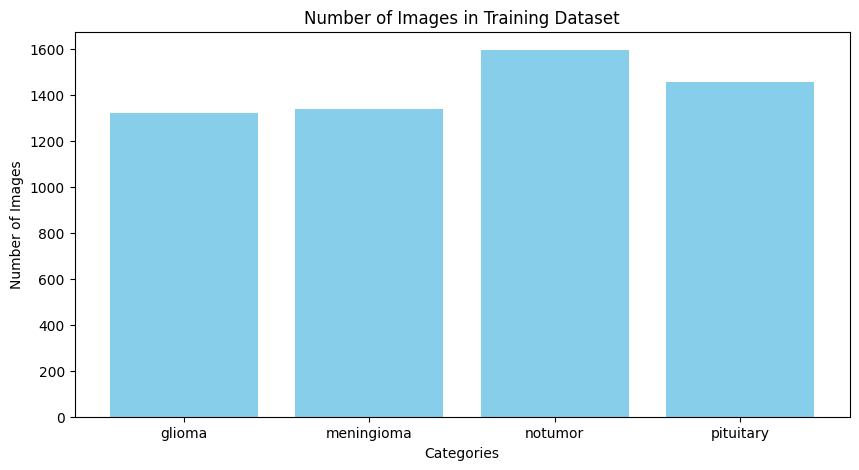

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Number of Images in Training Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Categories')
plt.show()

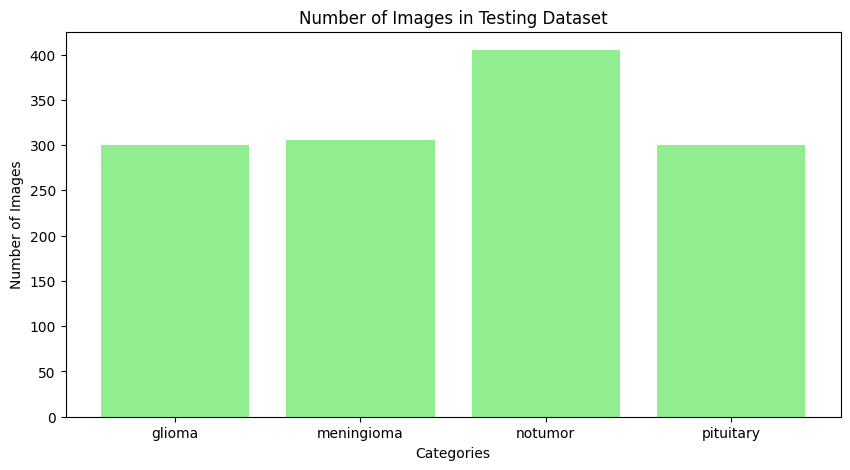

In [20]:
plt.figure(figsize=(10, 5))
plt.bar(test_counts.keys(), test_counts.values(), color='lightgreen')
plt.title('Number of Images in Testing Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Categories')
plt.show()

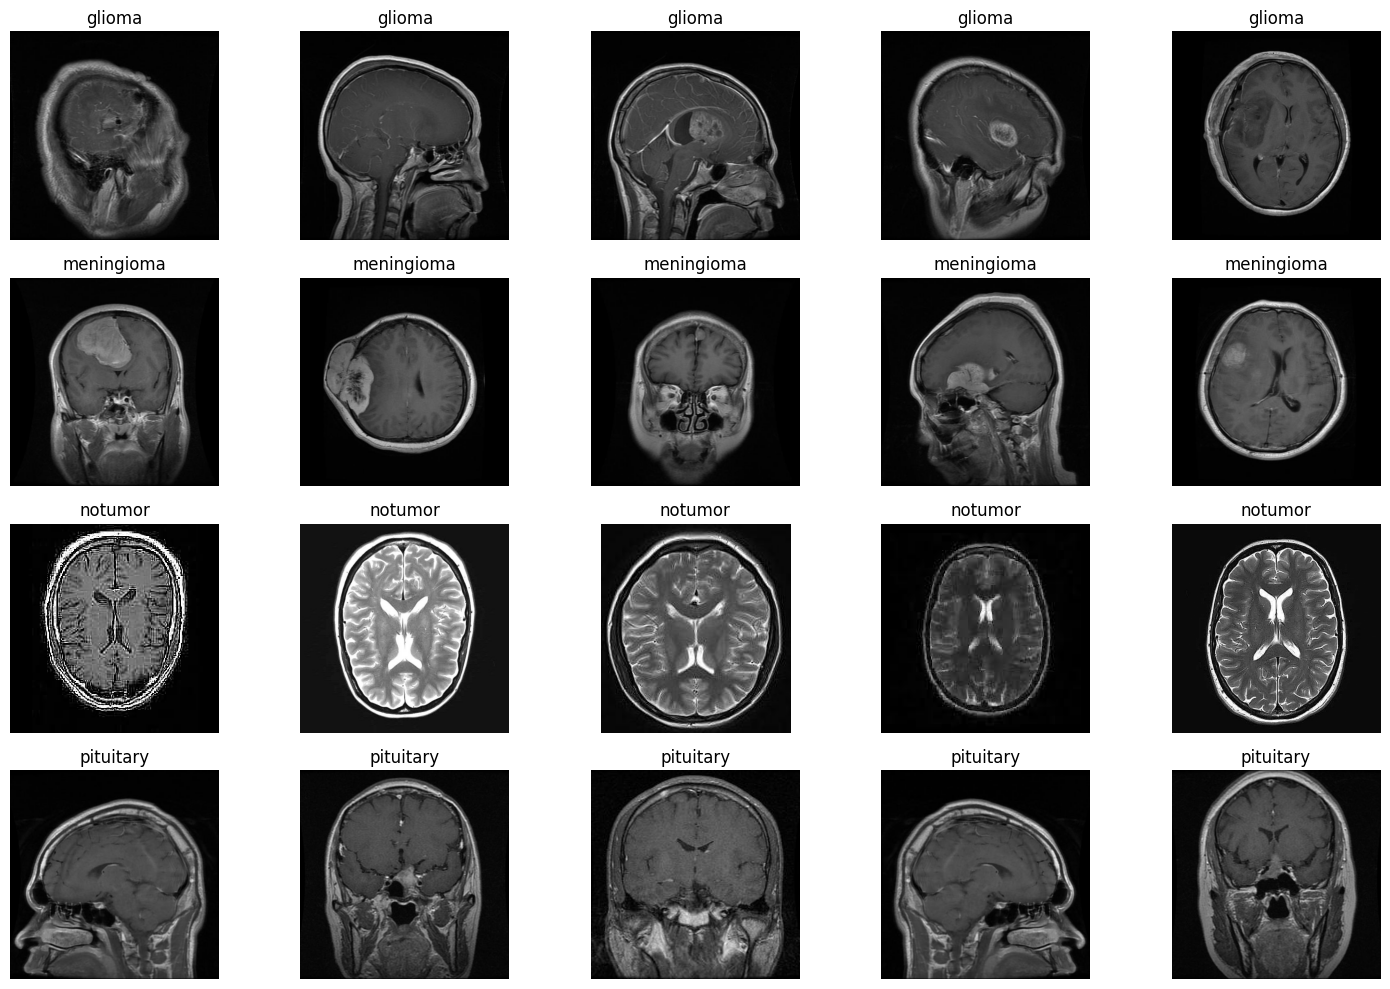

In [21]:
plot_sample_images(train_dir, categories, num_samples=5)

# Preprocessing/Data Augmentation

## Step 1: Define Paths and Remove Duplicates
- Set up paths for the training and testing directories.
- Use a custom function to find and remove duplicate images in both training and testing datasets. This function checks for duplicate files based on file content (using hash comparisons) and deletes any duplicates found.

---

## Step 2: Data Preprocessing and Data Augmentation
- Set up image dimensions (`img_size`) and batch size.
- Define the class labels for the dataset (glioma, meningioma, notumor, and pituitary).
- **Data Augmentation (Training)**: Create transformations to apply to the training images, including resizing, random horizontal flips, random rotation, and random resized cropping. These augmentations increase the diversity of the training data, helping the model generalize better.
- **Data Preprocessing (Validation/Test)**: For validation and testing datasets, apply only resizing and normalization transformations, without augmentation, to ensure consistent evaluations.

---

## Step 3: Load Dataset and Apply Transformations
- Load the dataset from the directory structure using `ImageFolder`, which automatically labels images based on folder names.
- Apply the data transformations defined earlier for training, validation, and testing sets.

---

## Step 4: Split Training Set into Training and Validation Sets
- Split the loaded training dataset into training and validation subsets. This is done to monitor model performance during training and avoid overfitting.
- Define a split ratio (e.g., 80% training, 20% validation) and use `random_split` to separate the dataset.

---

## Step 5: Create Data Loaders
- Use `DataLoader` to create iterable datasets for training, validation, and testing, which handle batching and shuffling automatically.
- Set `shuffle=True` for the training loader to randomize the order of images in each epoch, improving model learning.


In [22]:
batch_size = 32
img_size = 224  # Resize images to 224x224 for CNN input
num_classes = 4  # glioma, meningioma, notumor, pituitary
val_split = 0.2

In [23]:
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

In [25]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN Model

## Step 6: Define the CNN Model
- Define a Convolutional Neural Network (CNN) model with multiple convolutional layers, followed by max-pooling layers.
- The network includes fully connected layers and a dropout layer to prevent overfitting.
- Set up the final layer with `num_classes` neurons to output predictions for each class.

---

## Step 7: Initialize and Compile the Model
- Initialize the CNN model and transfer it to the GPU (if available) for faster computation.
- Define the loss function as `CrossEntropyLoss` and the optimizer as `Adam` to optimize model parameters during training.

---

## Step 8: Train the Model and Track Metrics
- Train the model over a specified number of epochs.
- For each epoch, compute training and validation metrics including Loss, Accuracy, Precision, Recall, and F1-score.
- Print the metrics for each epoch to monitor the model's progress over time.

---

## Step 9: Plot Training and Validation Metrics
- Plot the training and validation metrics across epochs to visualize model performance.
  - **Loss**: Observe how the model’s loss decreases over time for both training and validation datasets.
  - **Accuracy**: Track how the accuracy improves as the model learns.
  - **Precision, Recall, and F1-score**: Monitor these metrics to assess the model’s performance in handling imbalances and correctly classifying each class.

---

## Step 10: Evaluate the Model on Test Set and Plot Confusion Matrix
- Use the final trained model to make predictions on the test set.
- Calculate the test set’s accuracy, precision, recall, and F1-score to evaluate model performance.
- Plot a **Confusion Matrix** to visualize the distribution of predictions across each class, identifying areas where the model may be confusing certain classes.

In [27]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [28]:
model = CNN(num_classes=num_classes).to('cuda')  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [29]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20], Train Loss: 0.9240, Train Accuracy: 65.51%, Val Loss: 0.5374, Val Accuracy: 78.39%
Epoch [2/20], Train Loss: 0.5828, Train Accuracy: 77.30%, Val Loss: 0.4197, Val Accuracy: 83.81%
Epoch [3/20], Train Loss: 0.4885, Train Accuracy: 81.83%, Val Loss: 0.3635, Val Accuracy: 87.49%
Epoch [4/20], Train Loss: 0.3993, Train Accuracy: 84.59%, Val Loss: 0.3739, Val Accuracy: 85.65%
Epoch [5/20], Train Loss: 0.3626, Train Accuracy: 86.47%, Val Loss: 0.3200, Val Accuracy: 88.36%
Epoch [6/20], Train Loss: 0.3336, Train Accuracy: 87.15%, Val Loss: 0.2594, Val Accuracy: 90.99%
Epoch [7/20], Train Loss: 0.3022, Train Accuracy: 88.99%, Val Loss: 0.2514, Val Accuracy: 91.78%
Epoch [8/20], Train Loss: 0.2615, Train Accuracy: 90.17%, Val Loss: 0.2263, Val Accuracy: 91.78%
Epoch [9/20], Train Loss: 0.2561, Train Accuracy: 90.52%, Val Loss: 0.2524, Val Accuracy: 90.55%
Epoch [10/20], Train Loss: 0.2381, Train Accuracy: 91.20%, Val Loss: 0.2702, Val Accuracy: 91.43%
Epoch [11/20], Train Loss: 0.

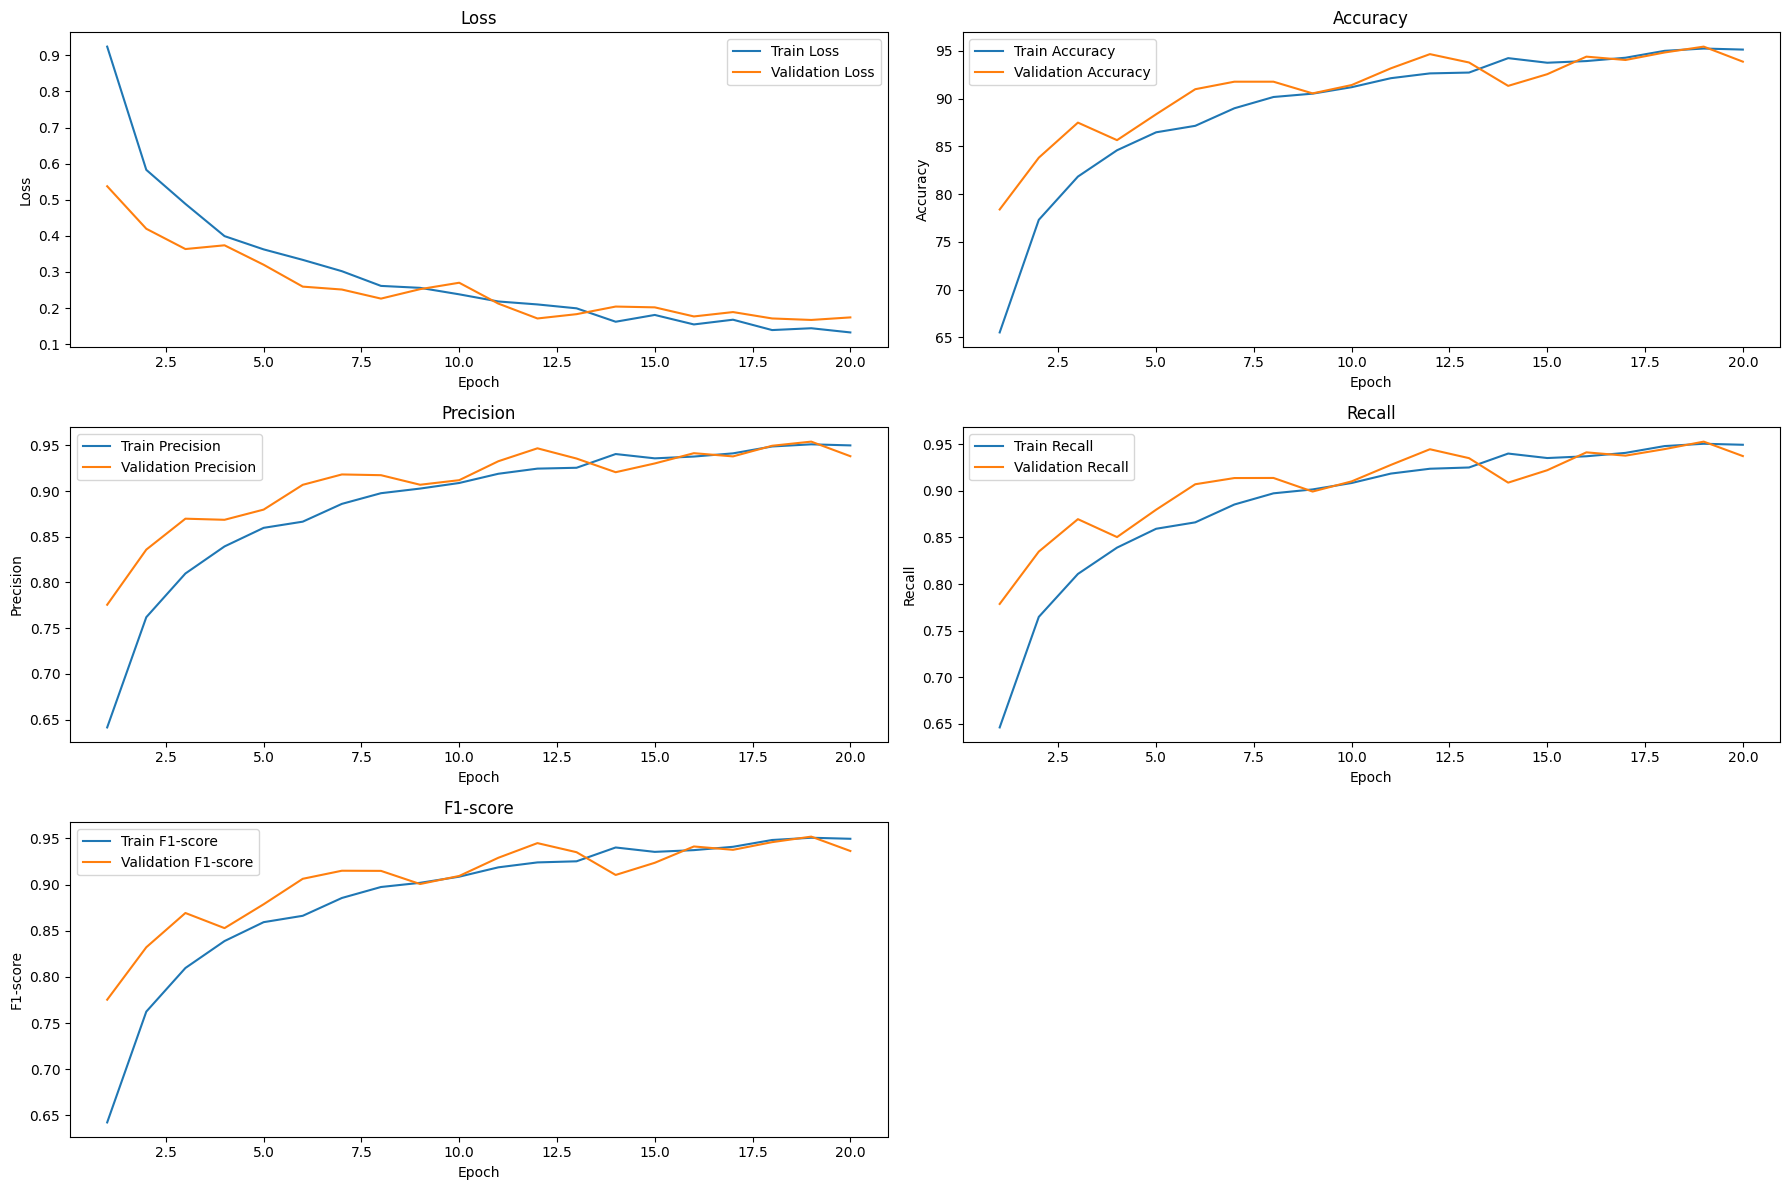

In [30]:
plot_metrics(history)

Accuracy on test set: 96.19%
Precision on test set: 0.96
Recall on test set: 0.96
F1-score on test set: 0.96


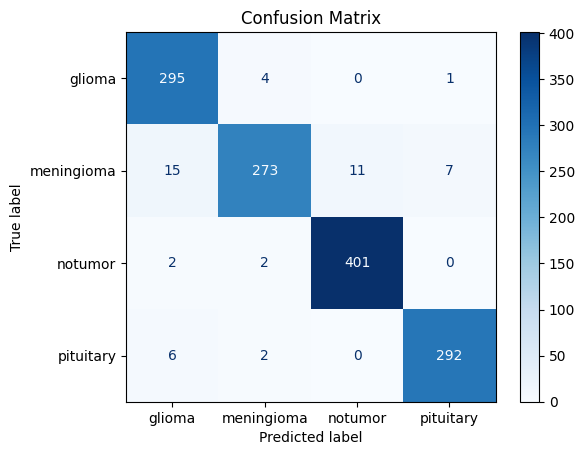

In [31]:
evaluate_model(model, test_loader)